# Homework:

Make plots (for 1 simulation):
### 1) utilization (4 bars)
- of Alice time with and witout Storage (what is percentage of time that Alice is waitng for Bob)
- of Bob's time with and witout Storage (what is percentage of time that Bob is waitng for Alice)
### 2) storage usage over time 

Use either Python or Julia

Provide code + 2 pictures (png format)

- if Alice has storage --> she doesn't wait. So, if there is a storage, than her utilization is 100% time
- Bob can wait because there are no boxes in the storage

utilization if the opposite of how much it's idle (100% of usage = 0% of waiting)

1 of bars is easy for sure:
- when there is a storage --> Alice doesn't for Bob and just starts a new box, hence her utilization is 100%

**but the question here is rather**: how much time she is actually spending working when there is no storage?

In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt

time_bob = np.array([ #[time, empirical; number of observations]
  [10 , 4],
  [20 , 6],
  [30 , 10],
  [40 , 20],
  [50 , 40],
  [60 , 11],
  [70 , 5],
  [80 , 4]
]) 

time_alice = np.array([ #[time, empirical; number of observations]
  [10 , 4],
  [20 , 5],
  [30 , 6],
  [40 , 7],
  [50 , 10],
  [60 , 8],
  [70 , 6],
  [80 , 2]       
])

print(time_bob)
print(time_bob.shape)

[[10  4]
 [20  6]
 [30 10]
 [40 20]
 [50 40]
 [60 11]
 [70  5]
 [80  4]]
(8, 2)


In [2]:
def min_vals(*args):
    vals = [v for v in args if v is not None]
    if len(vals)==0:
        return None
    return min(vals)

assert min_vals(1,2,3) == 1
assert min_vals(4,2,None) == 2
assert min_vals(None,None,None) == None

In [3]:
class ProductionLine:
    alice_action_end = 0  # time measured in seconds
    bob_action_end = None   
    alice_has_box = False #Alice holds or prepares box for Bob
    bob_has_box = False   #Bob works with box
    
    storage_counter = 0 ## number of boxes which are currently in the storage
    storage_counter_hist = []
    
    tick  = 0       # simulation step
    clock = 0       # time in simulated world in seconds
    clock_points = [] 
    completed_boxes = 0 # completed boxes
    
    alice_waiting_time = 0
    alice_cumulative_waiting_time = 0
    bob_waiting_time = 0
    bob_cumulative_waiting_time = 0

    def __init__(self,time_bob,time_alice,storage_active): #constructor
        self.time_alice = time_alice
        self.time_bob = time_bob        
        self.p_time_alice = time_alice[:,1]/np.sum(time_alice[:,1])
        self.p_time_bob = time_bob[:,1]/np.sum(time_bob[:,1]) 
        self.storage_active = storage_active ## new parameter to control scenario mode
    
    def step(self):
        #Selecting the next event to happen
        # Calculating the time of the next event to happen
        # Check if this event triggers another conditional action such as leaving the queue
        
        #Alice & Bob
        #Unconditional events: Alice completed job, Bob completed job
        #Conditional events: 
        # - Alice starts job (needs to have free hands)
        # - Bob starts job (needs to have free hands and a box must be available)
        
        #unconditional event
        self.clock = min_vals(self.alice_action_end,self.bob_action_end)
        
        # 1st scenario: Alice has a box the box but she needs to wait for a Bob
        if self.alice_has_box and self.bob_action_end is not None and self.bob_action_end > self.alice_action_end:
           ## if storage is active --> put finished box in a storage and start a new one:
            if self.storage_active:
                self.storage_counter += 1
                self.alice_has_box = False
                print(f"there are {self.storage_counter} boxes in storage")
                self.alice_cumulative_waiting_time = 0
            elif not self.storage_active:
                self.alice_waiting_time = (self.bob_action_end - self.alice_action_end)
                self.alice_cumulative_waiting_time += self.alice_waiting_time
                print(f"ALICE NEEDS TO WAIT FOR A BOB {self.alice_waiting_time} SECONDS. HER CUMULATIVE WAITING TIME NOW = {self.alice_cumulative_waiting_time}")
                self.clock = self.bob_action_end 
        
        # 2nd scenario: Alice is free and not doing anything --> then she takes a box
        if not self.alice_has_box:
            self.alice_has_box = True
            self.alice_action_end = self.clock + \
                    rd.choice(self.time_alice[:,0],p=self.p_time_alice)
            print(self.clock, "Alice starts doing new box for the time ", self.alice_action_end)

        # 3nd scenario: if Bob has box in his hands and he has just finished manufacturing the box
        if self.bob_has_box and self.bob_action_end <= self.clock:
            print(self.clock, "Bob finishes the box")
            self.completed_boxes += 1
            self.bob_action_end = None
            self.bob_has_box = False
        
       ## 5th scnario: Bob waiting for Alice condition
        if self.bob_action_end is None and self.clock < self.alice_action_end and self.clock > 0:
            if self.storage_active and self.storage_counter > 0: 
                self.bob_waiting_time = 0 
                self.bob_cumulative_waiting_time += self.bob_waiting_time 
            
            elif not self.storage_active:
                self.bob_waiting_time = (self.alice_action_end - self.clock)
                self.bob_cumulative_waiting_time += self.bob_waiting_time
                print(f"BOB NEEDS TO WAIT FOR ALICE {self.bob_waiting_time} SECONDS. HIS CUMULATIVE WAITING TIME NOW = {self.bob_cumulative_waiting_time}")
                
            
        # 4th scenario: if Alice has a box and Alice has finished a job --> Alice is ready to pass the box to Bob
        if self.alice_has_box and (self.alice_action_end is None or self.alice_action_end <= self.clock):
            print(self.clock, "Alice is ready to pass box to Bob ")
            if not self.bob_has_box:            
                self.bob_action_end = self.clock + \
                   rd.choice(self.time_bob[:,0],p=self.p_time_bob)
                print(self.clock, "Bob takes the box from Alice and will be ready at ",self.bob_action_end)
                self.bob_has_box = True
                self.alice_has_box = False
        
        self.tick = self.tick + 1 #increase step size
        if self.storage_active:
            self.clock_points.append(self.clock)
            self.storage_counter_hist.append(self.storage_counter)
        
    def status(self):
        print("### tick =",self.tick,"clock =",self.clock,"Alice has box", self.alice_has_box,"Alice end =",
              self.alice_action_end,
              "Bob end =",self.bob_action_end, "Bob has box =",self.bob_has_box,
              "completed_boxes =",self.completed_boxes)
        

In [4]:
rd.seed(10)
storage_active_values = [False, True]

for storage_status in storage_active_values:
    # Starting the model
    m = ProductionLine(time_bob, time_alice, storage_active=storage_status)
    for step in range(40):  
        m.step()
        m.status()
    print("results ----------------------------------------------")
    print(f"- overall time used by Alice = {m.alice_action_end}")
    print(f"- overall time used by Bob = {m.bob_action_end}")

    if m.storage_active:
        print(f"Alice cumulative waiting time with storage = {m.alice_cumulative_waiting_time}") 
        print(f"Bob cumulative waiting time with storage = {m.bob_cumulative_waiting_time}")
        alice_working_time_with_storage = round(((m.alice_action_end - m.alice_cumulative_waiting_time) / m.alice_action_end), 2) * 100
        bob_working_time_with_storage = round(((m.bob_action_end - m.bob_cumulative_waiting_time) / m.bob_action_end), 2) * 100
        print(f"Alice working time with storage = ({m.alice_action_end} - {m.alice_cumulative_waiting_time}) / {m.alice_action_end} = {alice_working_time_with_storage}")
        print(f"Bob working time with storage = ({m.bob_action_end} - {m.bob_cumulative_waiting_time}) / {m.bob_action_end} = {bob_working_time_with_storage}")
    elif not m.storage_active:
        print(f"Alice cumulative waiting time without storage = {m.alice_cumulative_waiting_time}")
        print(f"Bob cumulative waiting time without storage = {m.bob_cumulative_waiting_time}")
        alice_working_time_without_storage = round(((m.alice_action_end - m.alice_cumulative_waiting_time) / m.alice_action_end), 2) * 100
        bob_working_time_without_storage = round(((m.bob_action_end - m.bob_cumulative_waiting_time) / m.bob_action_end), 2) * 100
        print(f"Alice working time without storage = ({m.alice_action_end} - {m.alice_cumulative_waiting_time}) / {m.alice_action_end} = {alice_working_time_without_storage}")
        print(f"Bob working time without storage = ({m.bob_action_end} - {m.bob_cumulative_waiting_time}) / {m.bob_action_end} = {bob_working_time_without_storage}")  
    print("--------------------------------------------------------------------------")

0 Alice starts doing new box for the time  60
### tick = 1 clock = 0 Alice has box True Alice end = 60 Bob end = None Bob has box = False completed_boxes = 0
60 Alice is ready to pass box to Bob 
60 Bob takes the box from Alice and will be ready at  70
### tick = 2 clock = 60 Alice has box False Alice end = 60 Bob end = 70 Bob has box = True completed_boxes = 0
60 Alice starts doing new box for the time  110
### tick = 3 clock = 60 Alice has box True Alice end = 110 Bob end = 70 Bob has box = True completed_boxes = 0
70 Bob finishes the box
BOB NEEDS TO WAIT FOR ALICE 40 SECONDS. HIS CUMULATIVE WAITING TIME NOW = 40
### tick = 4 clock = 70 Alice has box True Alice end = 110 Bob end = None Bob has box = False completed_boxes = 1
110 Alice is ready to pass box to Bob 
110 Bob takes the box from Alice and will be ready at  160
### tick = 5 clock = 110 Alice has box False Alice end = 110 Bob end = 160 Bob has box = True completed_boxes = 1
110 Alice starts doing new box for the time  160
#

In [5]:
utility = {"Alice without storage": alice_working_time_without_storage, "Bob without storage": bob_working_time_without_storage, 
           "Alice with storage": alice_working_time_with_storage, "Bob with storage": bob_working_time_with_storage}

In [6]:
utility

{'Alice without storage': 64.0,
 'Bob without storage': 94.0,
 'Alice with storage': 100.0,
 'Bob with storage': 100.0}

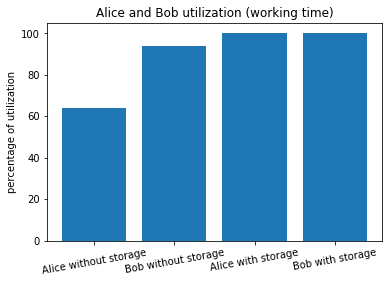

In [7]:
fig, ax = plt.subplots() 
names = list(utility.keys())
values = list(utility.values())
plt.bar(range(len(utility)),values,tick_label=names)
plt.xticks(rotation=10)
ax.set_title('Alice and Bob utilization (working time)')
plt.ylabel('percentage of utilization')
plt.savefig('utilization.png')
plt.show()

In [8]:
# print(len(m.storage_counter_hist))
# print(len(m.clock_points))
print(np.array(m.clock_points))
print(np.array(m.storage_counter_hist))
data = {"time":np.array(m.clock_points), "boxes at storage":np.array(m.storage_counter_hist)} 
  
df = pd.DataFrame(data)
df

[  0  10  10  60  60  90 120 160 160 200 220 220 260 290 290 310 330 350
 350 370 410 410 440 450 450 520 530 530 580 590 590 630 640 640 690 700
 740 740 750 780]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3]


,time,boxes at storage
0,0,0
1,10,0
2,10,0
3,60,0
4,60,0
5,90,1
6,120,1
7,160,1
8,160,1
9,200,1


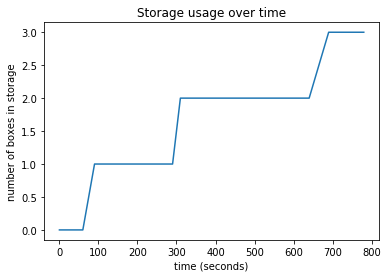

In [9]:
plt.plot(df["time"], df["boxes at storage"])
plt.title("Storage usage over time")
plt.xlabel("time (seconds)")
plt.ylabel("number of boxes in storage")
plt.savefig('storage_usage.png')
plt.show()